# Object Detection for Pallets in warehouse / Production lines

Import Libraries

In [122]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.patches as mpatches

import glob
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm
import cv2
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense
from pathlib import Path

Mount Google Drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading the training and testing files from drive

In [242]:
# Define Directory
images_directory = "/content/drive/My Drive/Colab Notebooks/pallet/images"
annotations_directory="/content/drive/My Drive/Colab Notebooks/pallet/annotations"

img_paths = sorted([os.path.join(images_directory, fname) for fname in os.listdir(images_directory) if fname.endswith(".jpg")])
label_paths = sorted([os.path.join(annotations_directory, fname) for fname in os.listdir(annotations_directory) if fname.endswith(".xml")])

k = len(img_paths)
print("image lenth:", k)
print("label lenth:", len(label_paths))

data_list = []

for i in range(k):
    annotation_file=label_paths[i]
    ds = BeautifulSoup(open(annotation_file).read(), "html.parser")

    # Iterating over each object elements
    for o in ds.find_all("object"):

        x_min = max(0, int(float(o.find("xmin").string)))
        y_min = max(0, int(float(o.find("ymin").string)))
        x_max = min(int(ds.find("width").string), int(float(o.find("xmax").string)))
        y_max = min(int(ds.find("height").string), int(float(o.find("ymax").string)))

    sample = [str(img_paths[i]), x_min, y_min, x_max, y_max]
    data_list.append(sample)

data = pd.DataFrame(data_list)

data['bbox'] = list(data[data.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
))

data['image_id'] = data.index.copy() +1
print(data.shape)
data.head()

image lenth: 100
label lenth: 100
(100, 7)


,0,1,2,3,4,bbox,image_id
0,/content/drive/My Drive/Colab Notebooks/pallet...,7,9,416,322,"7,9,416,322",1
1,/content/drive/My Drive/Colab Notebooks/pallet...,129,128,167,144,"129,128,167,144",2
2,/content/drive/My Drive/Colab Notebooks/pallet...,109,43,217,87,"109,43,217,87",3
3,/content/drive/My Drive/Colab Notebooks/pallet...,177,49,416,416,"177,49,416,416",4
4,/content/drive/My Drive/Colab Notebooks/pallet...,218,127,289,210,"218,127,289,210",5


xmin 7 ymin 9 xmax 416 ymax 322


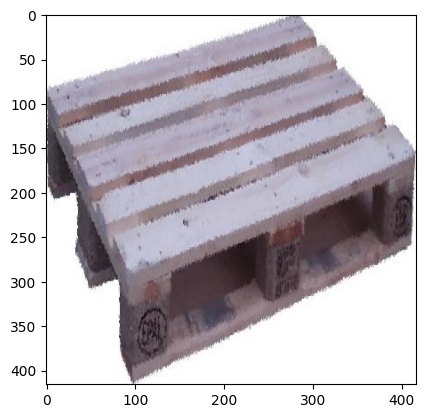

In [244]:
img = plt.imread(data[0][0])
plt.imshow(img)
print('xmin', data[1][0], 'ymin',data[2][0],'xmax',data[3][0],'ymax',data[4][0])

In [245]:
train_image_ids = np.unique(data.index.values)[1:71]
val_image_ids = np.unique(data.index.values)[71:101]
print("train_image_ids: ", len(train_image_ids))
print("val_image_ids: ", len(val_image_ids))

train_pixels = {}
train_labels = {}


def load_image(img_id):
    image = Image.open("/content/drive/My Drive/Colab Notebooks/pallet/images/" + str(img_id) + ".jpg")
    image = image.resize((256, 256))

    return np.asarray(image)


for count in tqdm(train_image_ids):
    train_pixels['image_id'] = load_image(count)
    train_labels['image_id'] = data['image_id'].copy() / 4

train_image_ids:  70
val_image_ids:  29


  0%|          | 0/70 [00:00<?, ?it/s]

In [246]:
val_pixels = {}
val_labels = {}

for count in tqdm(val_image_ids):
    val_pixels['image_id'] = load_image(count)
    val_labels['image_id'] =  data['image_id'].copy() / 4

  0%|          | 0/29 [00:00<?, ?it/s]

data gen

In [247]:
train = pd.DataFrame()
train[['xmin', 'ymin', 'xmax', 'ymax']] = data[[1, 2, 3, 4]].astype(int)
#train['image'] = train.index + 1
print(train.shape)
train.head(3)

(100, 4)


,xmin,ymin,xmax,ymax
0,7,9,416,322
1,129,128,167,144
2,109,43,217,87


In [248]:
rand_index = np.random.randint(0, train.shape[0])
print(rand_index)

65


## Defining training and testing path from the google drive

In [253]:
train_path = Path("/content/drive/My Drive/Colab Notebooks/pallet/train")
test_path = Path("/content/drive/My Drive/Colab Notebooks/pallet/test")

def data_generator(df=train, batch_size=16, path=train_path):
    while True:
        images = np.zeros((batch_size, 416,416,3)) #Set image as np
        bounding_box_coords = np.zeros((batch_size, 4))

        for i in range(batch_size): #no chg

                rand_index = np.random.randint(0, train.shape[0]) #generate a random index number
                row = df.loc[rand_index, :] #Get the bounding box
                #print("number of index: ", rand_index)
                path = "/content/drive/My Drive/Colab Notebooks/pallet/train/" + str(rand_index) + ".jpg"
                #path = "/content/drive/My Drive/Colab Notebooks/pallet/train/" + "32" + ".jpg"
                print("path: ", path)
                images[i] = cv2.imread(path) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax]) #Set bounding box coordinates

        yield {'image': images}, {'coords': bounding_box_coords}



## Using a generator to generate an iteration.
Generators are useful when we want to produce a large sequence of values, but we don't want to store all of them in memory at once.

number of index:  6
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/6.jpg
bbox_coords:  [307. 191. 387. 232.]


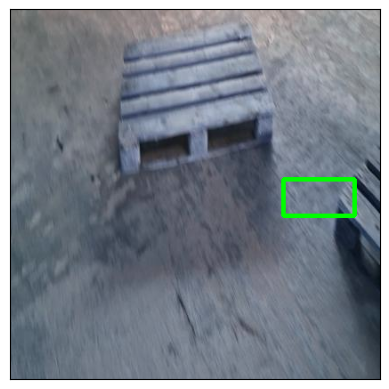

In [254]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]
print('bbox_coords: ', bbox_coords)


def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255. #Divide by 255 normalization
        img = img.astype(np.uint8)

    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

display_image(img, bbox_coords=bbox_coords, norm=True)

Result above is not accurate as we have not started to train the model.

# Defining the Model
Utilize Keras' functional API & start with large neural networks

In [255]:
input_ = Input(shape=[416,416,3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 416, 416, 3)]     0         
                                                                 
 conv2d_146 (Conv2D)         (None, 416, 416, 8)       224       
                                                                 
 batch_normalization_144 (Ba  (None, 416, 416, 8)      32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 208, 208, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_147 (Conv2D)         (None, 208, 208, 16)      1168      
                                                                 
 batch_normalization_145 (Ba  (None, 208, 208, 16)     64  

## Compile the model and define the metrics
We chose MSE and Accuracy as the main metrics

In [256]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

## Function to test the models

In [257]:
def test_model(model, datagen):
    example, label = next(datagen)

    X = example['image']
    y = label['coords']

    pred_bbox = model.predict(X)[0]

    img = X[0]
    gt_coords = y[0]

    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

Demo testing > Produce nothing as this is before model training

number of index:  8
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/8.jpg
1/1 [==============================] - 1s 610ms/step
number of index:  63
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/63.jpg
1/1 [==============================] - 0s 240ms/step
number of index:  63
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/63.jpg
1/1 [==============================] - 0s 230ms/step


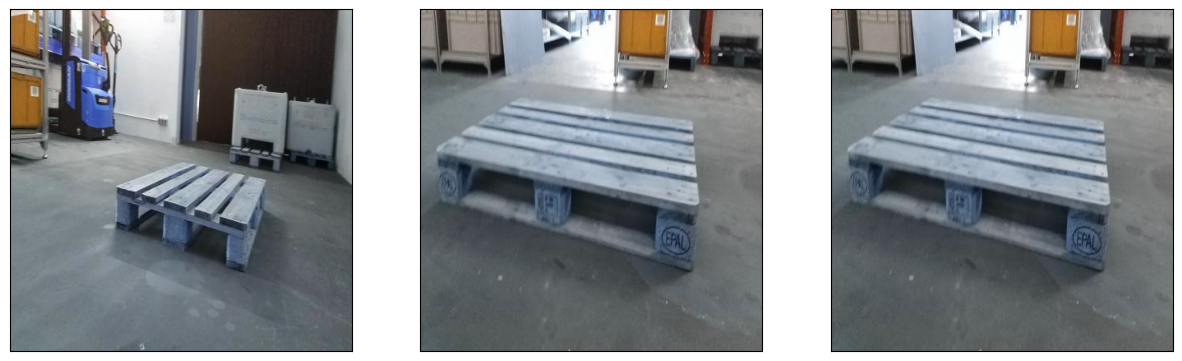

In [258]:
test(model)

## Model training with below Parameters

In [ ]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )

Streaming output truncated to the last 5000 lines.
number of index:  87
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/87.jpg
number of index:  79
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/79.jpg
number of index:  12
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/12.jpg
number of index:  60
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/60.jpg
 61/500 [==>...........................] - ETA: 2:11:26 - loss: 14197.3057 - accuracy: 0.7551number of index:  62
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/62.jpg
number of index:  25
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/25.jpg
number of index:  74
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/74.jpg
number of index:  96
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/96.jpg
number of index:  6
path:  /content/drive/My Drive/Colab Notebooks/pallet/train/6.jpg
number of index:  98
path:  /content/drive/My Drive/Colab Notebook

KeyboardInterrupt: ignored

## Save model if necessary

In [ ]:
#model.save('pallet_detection_model.h5')